In [3]:
import numpy as np
import pandas as pd
import ccxt
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
import talib
import requests
from gym import spaces, Env

url = "https://api.binance.com/api/v3/klines"
params = {
    'symbol': 'BTCUSDT',  # The trading pair
    'interval': '1m',     # 1-minute candlesticks
    'limit': 50000        # Number of data points to fetch
}

response = requests.get(url, params=params)
data = response.json()

if response.status_code == 200:
    data = pd.DataFrame(
        data,
        columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 
                    'close_time', 'quote_asset_volume', 'number_of_trades', 
                    'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    )
    data = data[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    #data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    # data.set_index('timestamp', inplace=True)
    data = data.astype(float)
else:
    print(f"Error: {response.status_code}, {response.text}")
data
data.to_csv('btc_data.csv', index=False)

In [379]:
import pandas as pd

# Simple Moving Average (SMA)
def SMA(data, period=14, column='close'):
    return data[column].rolling(window=period).mean()

# Exponential Moving Average (EMA)
def EMA(data, period=14, column='close'):
    return data[column].ewm(span=period, adjust=False).mean()

# Average Directional Index (ADX)
def ADX(data, period=14):
    high, low, close = data['high'], data['low'], data['close']
    plus_dm = high.diff().clip(lower=0)
    minus_dm = -low.diff().clip(upper=0)
    tr = pd.concat([high - low, abs(high - close.shift(1)), abs(low - close.shift(1))], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    plus_di = 100 * (plus_dm.ewm(span=period, adjust=False).mean() / atr)
    minus_di = 100 * (minus_dm.ewm(span=period, adjust=False).mean() / atr)
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    return dx.rolling(window=period).mean().dropna()

# Directional Indicator (+DI, -DI)
def calculate_di(data, period=14):
    high, low, close = data['high'], data['low'], data['close']
    plus_dm = high.diff().clip(lower=0)
    minus_dm = -low.diff().clip(upper=0)
    tr = pd.concat([high - low, abs(high - close.shift(1)), abs(low - close.shift(1))], axis=1).max(axis=1)
    data['+DI'] = (plus_dm.rolling(window=period).sum() / tr.rolling(window=period).sum()) * 100
    data['-DI'] = (minus_dm.rolling(window=period).sum() / tr.rolling(window=period).sum()) * 100
    return data[['+DI', '-DI']].dropna()

# Ichimoku Cloud
def Ichimoku(data):
    high, low = data['high'], data['low']
    data['Tenkan-sen'] = (high.rolling(9).max() + low.rolling(9).min()) / 2
    data['Kijun-sen'] = (high.rolling(26).max() + low.rolling(26).min()) / 2
    data['Senkou Span A'] = ((data['Tenkan-sen'] + data['Kijun-sen']) / 2).shift(26)
    data['Senkou Span B'] = ((high.rolling(52).max() + low.rolling(52).min()) / 2).shift(26)
    data['Chikou Span'] = data['close'].shift(-26)
    return data[['Tenkan-sen', 'Kijun-sen', 'Senkou Span A', 'Senkou Span B', 'Chikou Span']].dropna()

# Relative Strength Index (RSI)
def RSI(data, period=14, column='close'):
    delta = data[column].diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    return (100 - (100 / (1 + rs))).dropna()

# Moving Average Convergence Divergence (MACD)
def MACD(data, short_period=12, long_period=26, signal_period=9):
    short_ema = EMA(data, short_period)
    long_ema = EMA(data, long_period)
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line.dropna(), signal_line.dropna()

# Stochastic Oscillator
def Stochastic_Oscillator(data, period=14):
    high, low, close = data['high'], data['low'], data['close']
    lowest_low = low.rolling(window=period).min()
    highest_high = high.rolling(window=period).max()
    k = 100 * ((close - lowest_low) / (highest_high - lowest_low))
    d = k.rolling(window=3).mean()
    return k.dropna(), d.dropna()

# On-Balance Volume (OBV)
def OBV(data):
    obv = ((data['close'].diff() > 0) * data['volume'] - (data['close'].diff() < 0) * data['volume']).cumsum()
    return obv.dropna()

# Volume-Weighted Average Price (VWAP)
def VWAP(data):
    return ((data['close'] * data['volume']).cumsum() / data['volume'].cumsum()).dropna()

# Bollinger Bands
def Bollinger_Bands(data, period=20):
    sma = SMA(data, period)
    std = data['close'].rolling(window=period).std()
    return (sma + 2 * std).dropna(), (sma - 2 * std).dropna()

# Average True Range (ATR)
def ATR(data, period=14):
    high, low, close = data['high'], data['low'], data['close']
    tr = pd.concat([high - low, abs(high - close.shift()), abs(low - close.shift())], axis=1).max(axis=1)
    return tr.rolling(window=period).mean().dropna()

# Keltner Channel
def Keltner_Channel(data, period=20):
    ema = EMA(data, period)
    atr = ATR(data, period)
    return (ema + 2 * atr).dropna(), (ema - 2 * atr).dropna()

# Ensure 'data' is a DataFrame
if isinstance(data, list):
    data = pd.DataFrame(data)

# Calculate Indicators and Add to DataFrame
data['SMA_50'] = SMA(data, 50)
data['EMA_20'] = EMA(data, 20)
data['EMA_50'] = EMA(data, 50)
data['EMA_200'] = EMA(data, 200)
data['ADX_14'] = ADX(data, 14)

# Merge Ichimoku indicators
ichimoku = Ichimoku(data)
data = pd.concat([data, ichimoku], axis=1)

# Add Directional Indicators
data[['+DI', '-DI']] = calculate_di(data, 14)

# Add Other Indicators
data['RSI_14'] = RSI(data, 14)
data['MACD'], data['MACD_Signal'] = MACD(data)
data['Stoch_K'], data['Stoch_D'] = Stochastic_Oscillator(data)
data['OBV'] = OBV(data)
data['VWAP'] = VWAP(data)
data['BB_Upper'], data['BB_Lower'] = Bollinger_Bands(data)
data['ATR_14'] = ATR(data, 14)
data['Keltner_Upper'], data['Keltner_Lower'] = Keltner_Channel(data)

# Drop NaN values across all calculated indicators
data = data.dropna()

# Print the last few rows of the DataFrame
print(data.tail())


                         open      high       low     close    volume  \
timestamp                                                               
2025-02-12 18:15:00  97092.36  97115.14  97010.67  97032.16   6.14115   
2025-02-12 18:16:00  97032.17  97056.96  97023.50  97056.66   7.00358   
2025-02-12 18:17:00  97056.67  97066.90  96964.82  96981.14  11.48832   
2025-02-12 18:18:00  96981.14  97016.19  96981.13  96998.56   6.20687   
2025-02-12 18:19:00  96998.56  96998.57  96967.00  96980.46  16.40400   

                         SMA_50        EMA_20        EMA_50       EMA_200  \
timestamp                                                                   
2025-02-12 18:15:00  97262.8100  97096.580007  97112.123298  96470.276190   
2025-02-12 18:16:00  97260.5180  97092.778102  97109.948267  96476.110855   
2025-02-12 18:17:00  97254.5408  97082.145902  97104.896962  96481.136020   
2025-02-12 18:18:00  97244.8720  97074.185340  97100.726886  96486.284518   
2025-02-12 18:19:00  97234

<h1>Trading Indicators Guide</h1>

<h2>1. Trend Indicators 📈 (Detect Market Direction)</h2>

<h3>(a) Simple Moving Average (SMA) & Exponential Moving Average (EMA)</h3>
<p><strong>✅ What It Detects:</strong></p>
<ul>
    <li>SMA: Long-term trend direction.</li>
    <li>EMA: Short-term trend with more weight on recent prices.</li>
</ul>
<p><strong>📊 How to Interpret Results:</strong></p>
<ul>
    <li>Price above SMA/EMA → Uptrend (Bullish signal)</li>
    <li>Price below SMA/EMA → Downtrend (Bearish signal)</li>
    <li>Golden Cross (50 EMA > 200 EMA) → Strong Bullish</li>
    <li>Death Cross (50 EMA < 200 EMA) → Strong Bearish</li>
</ul>
<h3>(b) Average Directional Index (ADX)</h3>
<p><strong>✅ What It Detects:</strong></p>
<ul>
    <li>Strength of a trend (not direction).</li>
</ul>
<p><strong>📊 How to Interpret Results:</strong></p>
<ul>
    <li>ADX > 25 → Strong trend (either bullish or bearish).</li>
    <li>ADX < 20 → Weak trend (sideways movement).</li>
    <li>Increasing ADX → Trend is gaining strength.</li>
    <li>Decreasing ADX → Trend is weakening.</li>
</ul>

<h3>(c) Ichimoku Cloud</h3>
<p><strong>✅ What It Detects:</strong></p>
<ul>
    <li>Trend direction, support/resistance, and momentum.</li>
</ul>
<p><strong>📊 How to Interpret Results:</strong></p>
<ul>
    <li>Price above the cloud → Bullish trend.</li>
    <li>Price below the cloud → Bearish trend.</li>
    <li>Price inside the cloud → Consolidation/Uncertainty.</li>
</ul>

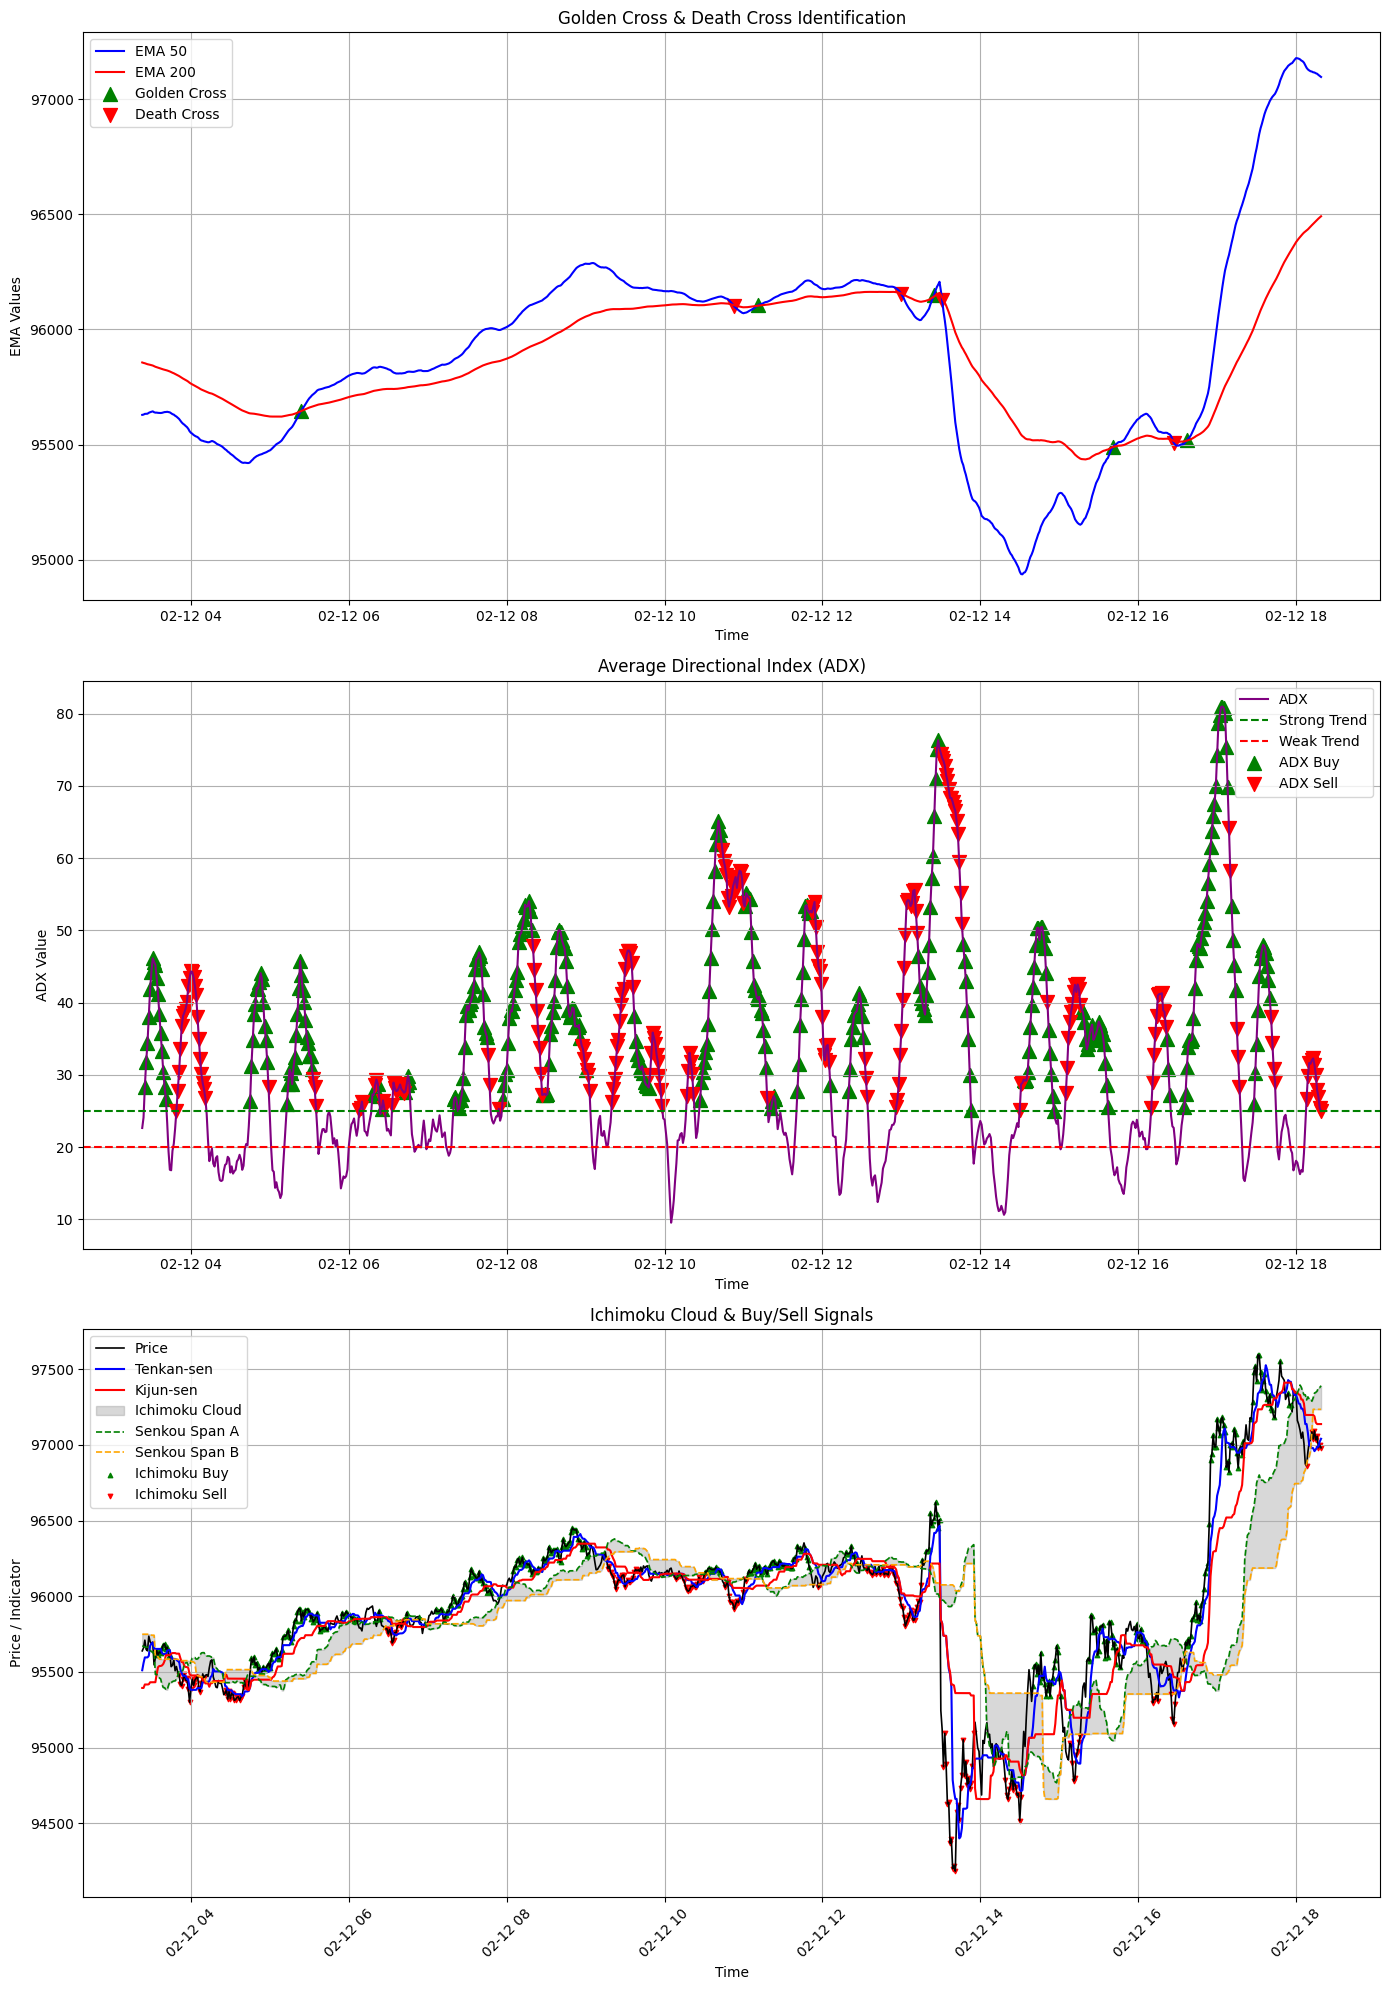

In [380]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_trends_and_ichimoku_with_signals(data):
    # Ensure the dataset is sorted by timestamp if not already
    data.index = pd.to_datetime(data.index)
    data = data.sort_values("timestamp")  # Ensure data is sorted

    # Drop duplicate columns for Senkou Span A and Senkou Span B
    data = data.loc[:, ~data.columns.duplicated()]

    # Generate Buy/Sell signals based on the conditions

    # Golden Cross / Death Cross based on EMA
    data['Golden_Cross'] = (data["EMA_50"].shift(1) < data["EMA_200"].shift(1)) & (data["EMA_50"] > data["EMA_200"])
    data['Death_Cross'] = (data["EMA_50"].shift(1) > data["EMA_200"].shift(1)) & (data["EMA_50"] < data["EMA_200"])

    # ADX Buy/Sell signals
    data['ADX_Buy'] = (data["ADX_14"] > 25) & (data["+DI"] > data["-DI"])  # Buy when ADX > 25 and +DI > -DI
    data['ADX_Sell'] = (data["ADX_14"] > 25) & (data["-DI"] > data["+DI"])  # Sell when ADX > 25 and -DI > +DI

    # Ichimoku Cloud Buy/Sell signals
    data['Ichimoku_Buy'] = (data['close'] > data['Senkou Span A']) & (data['close'] > data['Senkou Span B']) & (data['Tenkan-sen'] > data['Kijun-sen'])
    data['Ichimoku_Sell'] = (data['close'] < data['Senkou Span A']) & (data['close'] < data['Senkou Span B']) & (data['Tenkan-sen'] < data['Kijun-sen'])

    # Plotting the signals along with the trends

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 20))

    # Plot EMAs (EMA 50 & EMA 200)
    ax1.plot(data.index, data["EMA_50"], label="EMA 50", color="blue", linewidth=1.5)
    ax1.plot(data.index, data["EMA_200"], label="EMA 200", color="red", linewidth=1.5)
    ax1.scatter(data.index[data["Golden_Cross"]], data["EMA_50"][data["Golden_Cross"]], color="green", marker="^", label="Golden Cross", s=100)
    ax1.scatter(data.index[data["Death_Cross"]], data["EMA_50"][data["Death_Cross"]], color="red", marker="v", label="Death Cross", s=100)
    ax1.set_title("Golden Cross & Death Cross Identification")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("EMA Values")
    ax1.legend()
    ax1.grid()

    # Plot ADX and Buy/Sell signals
    ax2.plot(data.index, data["ADX_14"], label="ADX", color="purple", linewidth=1.5)
    ax2.axhline(25, color='green', linestyle='--', label="Strong Trend")
    ax2.axhline(20, color='red', linestyle='--', label="Weak Trend")
    ax2.scatter(data.index[data["ADX_Buy"]], data["ADX_14"][data["ADX_Buy"]], color="green", marker="^", label="ADX Buy", s=100)
    ax2.scatter(data.index[data["ADX_Sell"]], data["ADX_14"][data["ADX_Sell"]], color="red", marker="v", label="ADX Sell", s=100)
    ax2.set_title("Average Directional Index (ADX)")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("ADX Value")
    ax2.legend()
    ax2.grid()

    # Plot Ichimoku Cloud and Buy/Sell signals
    ax3.plot(data.index, data['close'], label="Price", color="black", linewidth=1.2)
    ax3.plot(data.index, data['Tenkan-sen'], label="Tenkan-sen", color="blue", linewidth=1.5)
    ax3.plot(data.index, data['Kijun-sen'], label="Kijun-sen", color="red", linewidth=1.5)
    ax3.fill_between(data.index, data['Senkou Span A'], data['Senkou Span B'], color="gray", alpha=0.3, label="Ichimoku Cloud")
    ax3.plot(data.index, data['Senkou Span A'], label="Senkou Span A", color="green", linestyle="--", linewidth=1.2)
    ax3.plot(data.index, data['Senkou Span B'], label="Senkou Span B", color="orange", linestyle="--", linewidth=1.2)
    ax3.scatter(data.index[data["Ichimoku_Buy"]], data['close'][data["Ichimoku_Buy"]], color="green", marker="^", label="Ichimoku Buy", s=10)
    ax3.scatter(data.index[data["Ichimoku_Sell"]], data['close'][data["Ichimoku_Sell"]], color="red", marker="v", label="Ichimoku Sell", s=10)
    ax3.set_title("Ichimoku Cloud & Buy/Sell Signals")
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Price / Indicator")
    ax3.legend()
    ax3.grid()

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call function to generate plot
plot_trends_and_ichimoku_with_signals(data)


In [381]:
import pandas as pd

# Function to generate Buy/Sell signals based on ADX and Ichimoku
def generate_signals(data):
    # ADX Buy/Sell conditions
    data['ADX_Buy'] = (data["ADX_14"] > 25) & (data["+DI"] > data["-DI"])
    data['ADX_Sell'] = (data["ADX_14"] > 25) & (data["-DI"] > data["+DI"])

    # Ichimoku Buy/Sell conditions
    data['Ichimoku_Buy'] = (data['close'] > data['Senkou Span A']) & \
                           (data['close'] > data['Senkou Span B']) & \
                           (data['Tenkan-sen'] > data['Kijun-sen'])

    data['Ichimoku_Sell'] = (data['close'] < data['Senkou Span A']) & \
                            (data['close'] < data['Senkou Span B']) & \
                            (data['Tenkan-sen'] < data['Kijun-sen'])

    return data

# Function to calculate win/loss with 10% fee
def calculate_win_loss(data):
    initial_balance = 1000  # Starting money
    balance = initial_balance
    position = 0  # Number of units held
    buy_price = 0

    for i in range(len(data)):
        row = data.iloc[i]

        # Check for buy signal
        if row['ADX_Buy'] or row['Ichimoku_Buy']:
            buy_price = row['close'] * 1.10  # Add 10% fee
            position = balance / buy_price  # Buy with full balance
            balance = 0  # Spend all balance

        # Check for sell signal
        elif row['ADX_Sell'] or row['Ichimoku_Sell']:
            if position > 0:  # Ensure we have something to sell
                sell_price = row['close'] * 0.90  # Subtract 10% fee
                balance = position * sell_price  # Sell all
                position = 0  # Clear holdings

    final_balance = balance if position == 0 else position * data.iloc[-1]['close'] * 0.90  # Sell last if holding

    profit_loss = final_balance - initial_balance
    win_loss_percentage = (profit_loss / initial_balance) * 100

    print(f"Final Balance: ${final_balance:.2f}")
    print(f"Profit/Loss: ${profit_loss:.2f} ({win_loss_percentage:.2f}%)")

# Apply functions
data = generate_signals(data)
calculate_win_loss(data)


ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

ValueError: 'y1' is not 1-dimensional

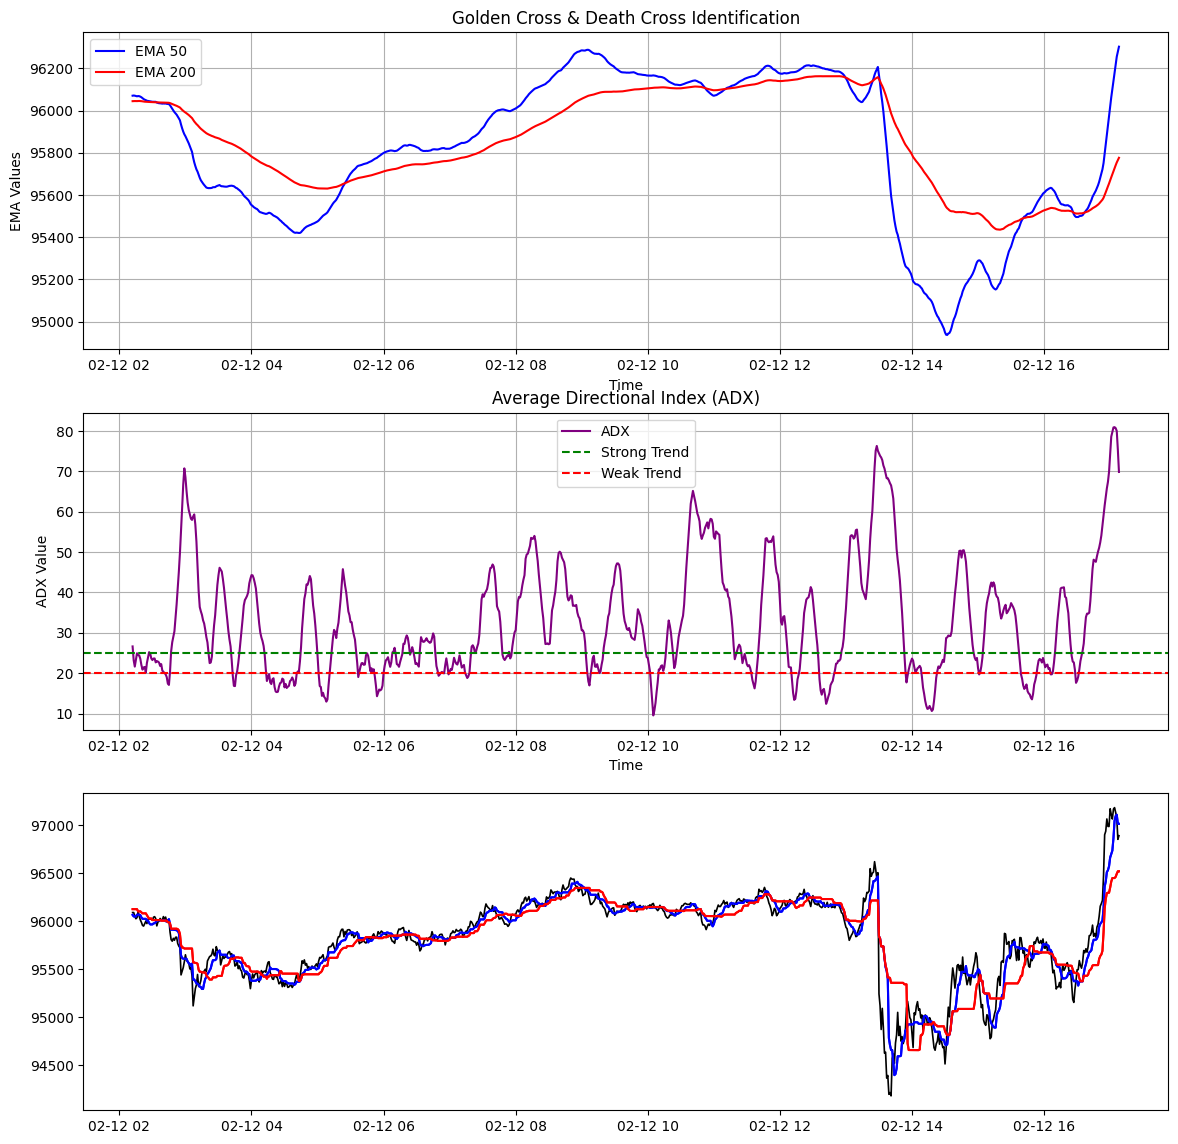

In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta

def plot_trends_and_ichimoku(data):
    # Convert timestamp column to datetime format if not already


    # Plot EMAs
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 14))

    ax1.plot(data.index, data["EMA_50"], label="EMA 50", color="blue", linewidth=1.5)
    ax1.plot(data.index, data["EMA_200"], label="EMA 200", color="red", linewidth=1.5)
    ax1.set_title("Golden Cross & Death Cross Identification")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("EMA Values")
    ax1.legend()
    ax1.grid()

    # ADX Plot
    ax2.plot(data.index, data["ADX_14"], label="ADX", color="purple", linewidth=1.5)
    ax2.axhline(25, color='green', linestyle='--', label="Strong Trend")
    ax2.axhline(20, color='red', linestyle='--', label="Weak Trend")
    ax2.set_title("Average Directional Index (ADX)")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("ADX Value")
    ax2.legend()
    ax2.grid()

    # Ichimoku Cloud Plot
    ax3.plot(data.index, data['close'], label="Price", color="black", linewidth=1.2)
    ax3.plot(data.index, data['Tenkan-sen'], label="Tenkan-sen", color="blue", linewidth=1.5)
    ax3.plot(data.index, data['Kijun-sen'], label="Kijun-sen", color="red", linewidth=1.5)
    ax3.fill_between(data.index, data['Senkou Span A'], data['Senkou Span B'], color="gray", alpha=0.3, label="Ichimoku Cloud")
    ax3.plot(data.index, data['Senkou Span A'], label="Senkou Span A", color="green", linestyle="--", linewidth=1.2)
    ax3.plot(data.index, data['Senkou Span B'], label="Senkou Span B", color="orange", linestyle="--", linewidth=1.2)
    ax3.set_title("Ichimoku Cloud")
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Price / Indicator")
    ax3.legend()
    ax3.grid()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call function to generate plot
plot_trends_and_ichimoku(data)


<h2>2. Momentum Indicators 🚀 (Measure Strength of Price Movement)</h2>

<h3>(a) Relative Strength Index (RSI)</h3>
<p><strong>✅ What It Detects:</strong></p>
<ul>
    <li>Overbought and oversold conditions (potential reversal points).</li>
</ul>
<p><strong>📊 How to Interpret Results:</strong></p>
<ul>
    <li>RSI > 70 → Overbought (Sell signal).</li>
    <li>RSI < 30 → Oversold (Buy signal).</li>
    <li>Divergence (Price rises but RSI falls) → Weakening trend, possible reversal.</li>
</ul>

<h3>(b) Moving Average Convergence Divergence (MACD)</h3>
<p><strong>✅ What It Detects:</strong></p>
<ul>
    <li>Trend direction, momentum, and reversals.</li>
</ul>
<p><strong>📊 How to Interpret Results:</strong></p>
<ul>
    <li>MACD line crosses above Signal line → Bullish crossover (Buy).</li>
    <li>MACD line crosses below Signal line → Bearish crossover (Sell).</li>
    <li>MACD Divergence → Price making higher highs while MACD falls → Possible trend reversal.</li>
</ul>

<h3>(c) Stochastic Oscillator</h3>
<p><strong>✅ What It Detects:</strong></p>
<ul>
    <li>Momentum shifts and overbought/oversold conditions.</li>
</ul>
<p><strong>📊 How to Interpret Results:</strong></p>
<ul>
    <li>%K > 80 → Overbought (Sell signal).</li>
    <li>%K < 20 → Oversold (Buy signal).</li>
    <li>%K crossing %D from below → Bullish reversal.</li>
    <li>%K crossing %D from above → Bearish reversal.</li>
</ul>

<h2>3. Volume Indicators 📊 (Confirm Market Strength)</h2>

<h3>(a) On-Balance Volume (OBV)</h3>
<p><strong>✅ What It Detects:</strong></p>
<ul>
    <li>Buying vs. selling pressure.</li>
</ul>
<p><strong>📊 How to Interpret Results:</strong></p>
<ul>
    <li>Rising OBV → Buying pressure (Bullish).</li>
    <li>Falling OBV → Selling pressure (Bearish).</li>
    <li>Divergence (Price rising, OBV falling) → Weak uptrend, possible reversal.</li>
</ul>

<h3>(b) Volume Weighted Average Price (VWAP)</h3>
<p><strong>✅ What It Detects:</strong></p>
<ul>
    <li>Trend strength based on volume-weighted prices.</li>
</ul>
<p><strong>📊 How to Interpret Results:</strong></p>
<ul>
    <li>Price above VWAP → Strong bullish trend.</li>
    <li>Price below VWAP → Strong bearish trend.</li>
    <li>VWAP flat → Market is ranging (no clear trend).</li>
</ul>

<h2>4. Volatility Indicators ⚡ (Measure Market Risk & Big Moves)</h2>

<h3>(a) Bollinger Bands (BB)</h3>
<p><strong>✅ What It Detects:</strong></p>
<ul>
    <li>Volatility and potential breakouts.</li>
</ul>
<p><strong>📊 How to Interpret Results:</strong></p>
<ul>
    <li>Price touches upper band → Overbought (Sell signal).</li>
    <li>Price touches lower band → Oversold (Buy signal).</li>
    <li>Bands expand → Increased volatility (Big move expected).</li>
    <li>Bands contract → Low volatility (Possible breakout).</li>
</ul>

<h3>(b) Average True Range (ATR)</h3>
<p><strong>✅ What It Detects:</strong></p>
<ul>
    <li>Market volatility (size of price movements).</li>
</ul>
<p><strong>📊 How to Interpret Results:</strong></p>
<ul>
    <li>High ATR → High volatility (Big price swings).</li>
    <li>Low ATR → Low volatility (Stable price movement).</li>
    <li>Rising ATR → Market getting volatile (Breakout possible).</li>
</ul>

<h3>(c) Keltner Channel</h3>
<p><strong>✅ What It Detects:</strong></p>
<ul>
    <li>Trend direction and volatility.</li>
</ul>
<p><strong>📊 How to Interpret Results:</strong></p>
<ul>
    <li>Price above upper band → Strong bullish move.</li>
    <li>Price below lower band → Strong bearish move.</li>
    <li>Price inside the bands → Normal market behavior.</li>
</ul>

<h2>Best Indicator Combinations for Different Trading Strategies</h2>

<table>
    <tr>
        <th>Strategy Type</th>
        <th>Best Indicator Combinations</th>
        <th>Why They Are Used</th>
        <th>When to Use</th>
    </tr>
    <tr>
        <td>Trend-Following</td>
        <td>EMA + ADX + Ichimoku Cloud</td>
        <td>
            - EMA identifies and smooths trend direction. <br>
            - ADX confirms trend strength. <br>
            - Ichimoku Cloud provides dynamic support/resistance.
        </td>
        <td>
            - When trading strong, sustained trends. <br>
            - Best for swing trading or long-term positions.
        </td>
    </tr>
    <tr>
        <td>Momentum-Based</td>
        <td>RSI + MACD + Stochastic Oscillator</td>
        <td>
            - RSI detects overbought/oversold levels. <br>
            - MACD confirms trend momentum and crossovers. <br>
            - Stochastic Oscillator identifies momentum shifts.
        </td>
        <td>
            - When looking for trend continuation or reversal points. <br>
            - Best in volatile markets for short-to-medium-term trades.
        </td>
    </tr>
    <tr>
        <td>Breakout Trading</td>
        <td>Bollinger Bands + ATR + OBV</td>
        <td>
            - Bollinger Bands detect price compression & potential breakouts. <br>
            - ATR confirms volatility expansion. <br>
            - OBV validates breakout strength with volume.
        </td>
        <td>
            - When trading breakouts from consolidation. <br>
            - Best before major news releases or key price levels.
        </td>
    </tr>
    <tr>
        <td>Mean Reversion</td>
        <td>RSI + Bollinger Bands + VWAP</td>
        <td>
            - RSI identifies extreme price conditions. <br>
            - Bollinger Bands highlight deviation from the mean. <br>
            - VWAP helps confirm fair value reversion.
        </td>
        <td>
            - When markets are ranging or after sharp price movements. <br>
            - Best for mean-reverting assets like stocks & forex pairs.
        </td>
    </tr>
    <tr>
        <td>Scalping/Day Trading</td>
        <td>VWAP + Stochastic RSI + Volume</td>
        <td>
            - VWAP acts as a dynamic support/resistance level. <br>
            - Stochastic RSI provides rapid momentum signals. <br>
            - Volume confirms market strength.
        </td>
        <td>
            - When trading intraday price movements. <br>
            - Best for high-frequency trading in liquid markets.
        </td>
    </tr>
</table>


14 32
22 52
32 76
36 77
42 97


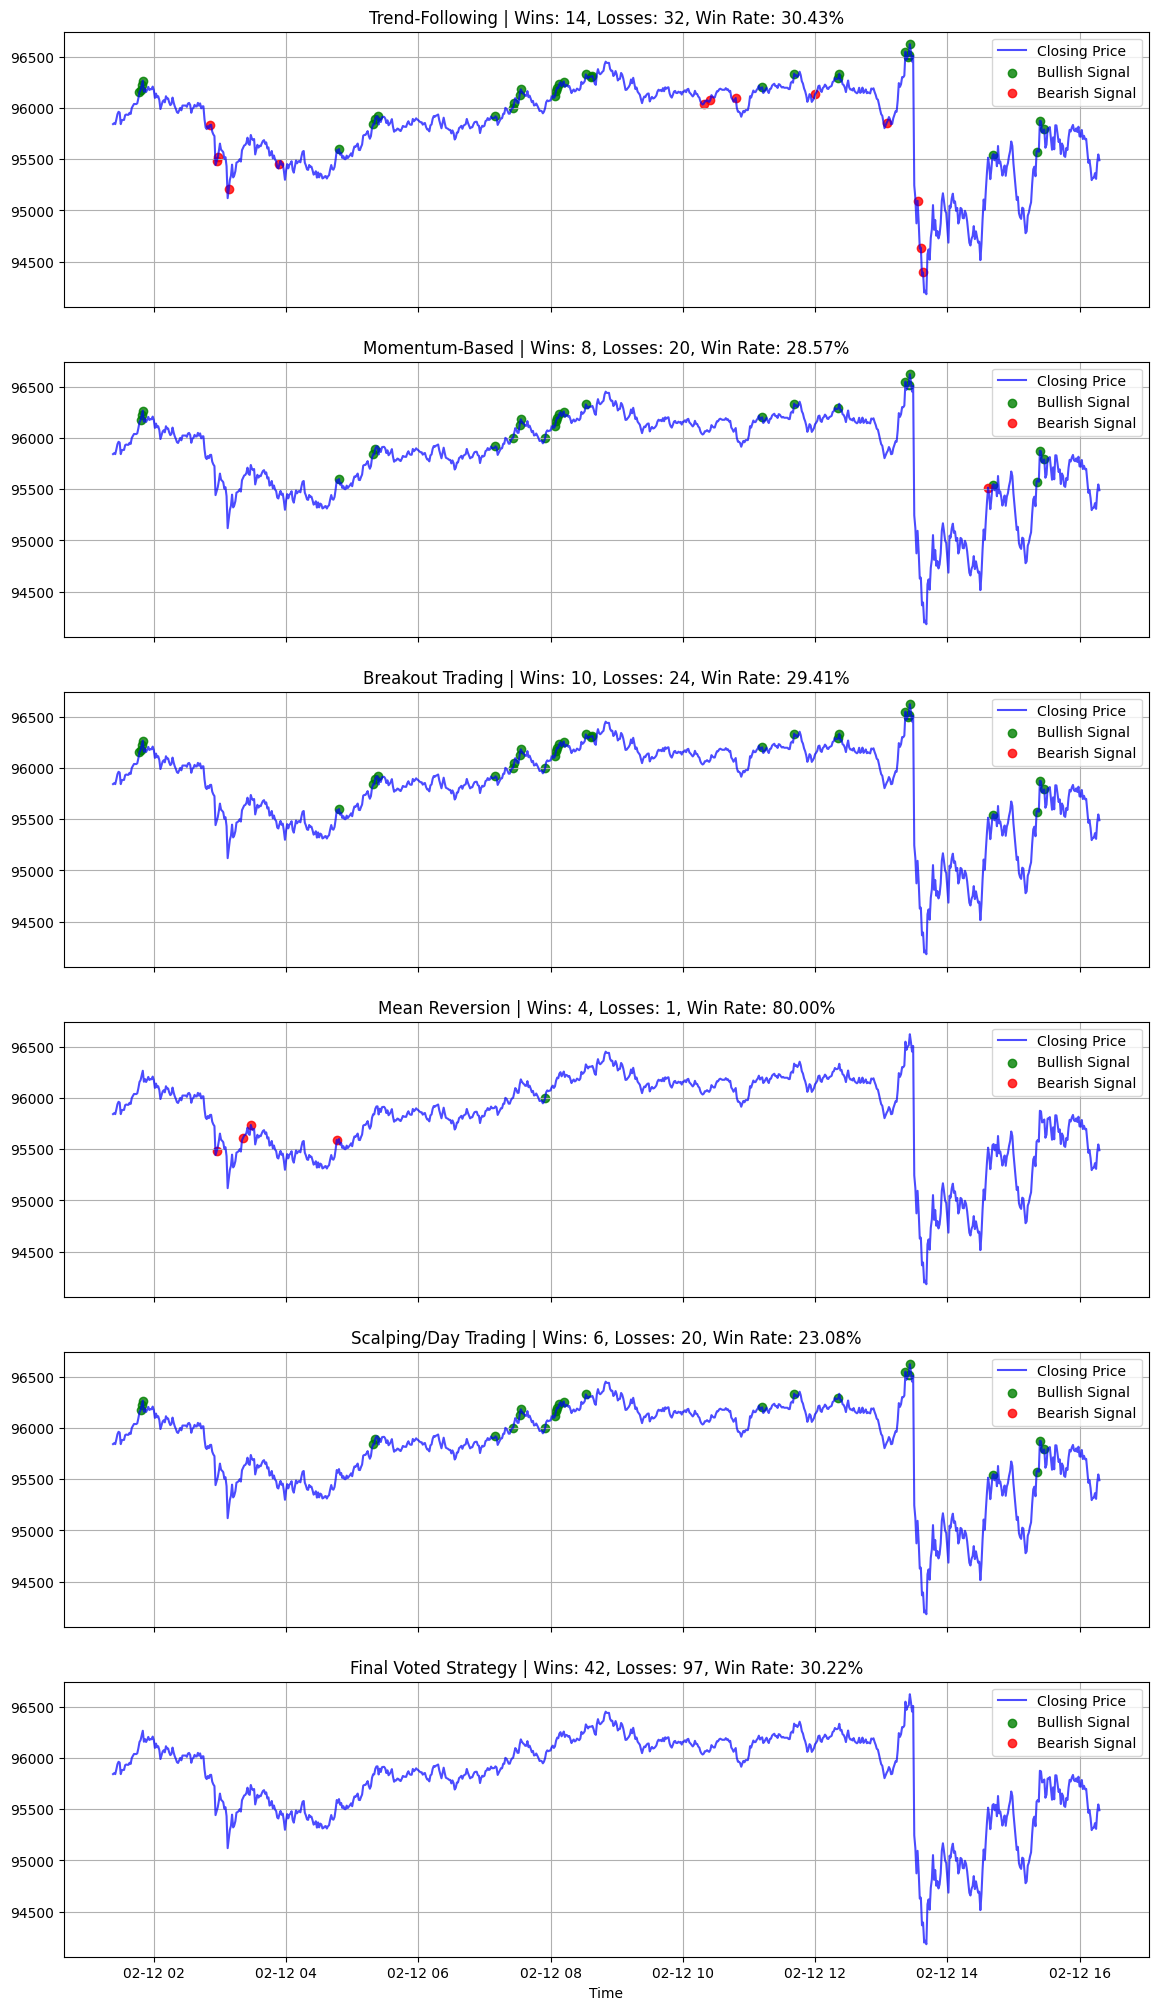

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trading_strategies(data, future_period=3):
    fig, axes = plt.subplots(6, 1, figsize=(14, 25), sharex=True)

    # Ensure previous values exist for comparison
    for ind in ["OBV", "ATR_14", "close"]:
        data[f"{ind}_prev"] = data[ind].shift(1)

    # Drop NaNs
    data = data.dropna()

    # Extract timestamps **without resetting index**
    timestamps = data.index  

    # Define trading strategies
    strategies = [
        ("Trend-Following", ["EMA_20", "ADX_14", "Senkou Span A"]),
        ("Momentum-Based", ["RSI_14", "MACD", "Stoch_K"]),
        ("Breakout Trading", ["BB_Upper", "ATR_14", "OBV"]),
        ("Mean Reversion", ["RSI_14", "BB_Lower", "VWAP"]),
        ("Scalping/Day Trading", ["VWAP", "Stoch_K", "volume"])
    ]

    bullish_votes = np.zeros(len(data))
    bearish_votes = np.zeros(len(data))

    final_bullish_signals, final_bearish_signals = [], []
    final_timestamps = []
    total_win_count, total_loss_count = 0, 0

    for i, (title, indicators) in enumerate(strategies):
        bullish_signals, bearish_signals = [], []
        signal_timestamps = []
        win_count, loss_count = 0, 0

        # Compute rolling mean beforehand (to avoid repeated calculations)
        rolling_volume_mean = data["volume"].rolling(20).mean()

        for j in range(len(data) - future_period):
            row = data.iloc[j].to_dict()
            
            # Calculate volume confirmation dynamically
            avg_volume = rolling_volume_mean.iloc[j]  # Use correct rolling mean for this row
            strong_volume_confirmed = row["volume"] > avg_volume * 1.05
            weak_volume_confirmed = row["volume"] > avg_volume
            
            # Final volume confirmation (either OBV or volume must confirm)
            is_volume_confirmed = (row["OBV"] > row["OBV_prev"]) or strong_volume_confirmed

            future_close = data["close"].iloc[j + future_period]
            bull_count, bear_count = 0, 0

            for ind in indicators:
                value = row.get(ind, None)

                if value is not None:
                    if ind.startswith("EMA") or ind.startswith("Senkou") or ind == "VWAP":
                        if row["close"] > value:
                            bull_count += 1
                        else:
                            bear_count += 1
                    elif ind.startswith("RSI"):
                        if value < 30:
                            bull_count += 1
                        elif value > 70:
                            bear_count += 1
                    elif ind.startswith("MACD"):
                        if row["MACD"] > row["MACD_Signal"]:
                            bull_count += 1
                        else:
                            bear_count += 1
                    elif ind.startswith("Stoch"):
                        if row["Stoch_K"] > row["Stoch_D"]:
                            bull_count += 1
                        else:
                            bear_count += 1
                    elif ind.startswith("BB_Upper"):
                        if row["close"] > row["BB_Upper"]:
                            bull_count += 1
                    elif ind.startswith("BB_Lower"):
                        if row["close"] < row["BB_Lower"]:
                            bear_count += 1
                    elif ind.startswith("OBV"):
                        if row["OBV"] > row["OBV_prev"] and row["close"] > row["close_prev"]:
                            bull_count += 1
                        elif row["OBV"] < row["OBV_prev"] and row["close"] < row["close_prev"]:
                            bear_count += 1
                    elif ind.startswith("ATR"):
                        if row["ATR_14"] > row["ATR_14_prev"] and row["close"] > row["close_prev"]:
                            bull_count += 1
                        elif row["ATR_14"] > row["ATR_14_prev"] and row["close"] < row["close_prev"]:
                            bear_count += 1
            
            # Define total indicators considered
            total_votes = bull_count + bear_count

            # Define trade conditions
            min_votes = total_votes * 0.66  # At least 66% must be bullish or bearish
            
            # Ensure market is trending before trading
            is_trending_up = row["EMA_20"] > row["EMA_50"] and row["ADX_14"] > 20
            is_trending_down = row["EMA_20"] < row["EMA_50"] and row["ADX_14"] > 20
            
            # Ensure RSI is not in the neutral range (sideways market)
            is_rsi_confirmed = row["RSI_14"] < 30 or row["RSI_14"] > 70

            # Confirm strong breakout with volume
            # Confirm strong breakout with volume
            is_volume_confirmed = row["OBV"] > row["OBV_prev"] and row["volume"] > data["volume"].rolling(20).mean().iloc[j]


            # Final Buy Condition
            if bull_count > min_votes and is_trending_up and is_rsi_confirmed and is_volume_confirmed:
                bullish_signals.append(data["close"].iloc[j])
                bearish_signals.append(None)
                signal_timestamps.append(timestamps[j])

                if future_close > data["close"].iloc[j]:
                    win_count += 1
                else:
                    loss_count += 1

            # Final Sell Condition
            elif bear_count > min_votes and is_trending_down and is_rsi_confirmed and is_volume_confirmed:
                bullish_signals.append(None)
                bearish_signals.append(data["close"].iloc[j])
                signal_timestamps.append(timestamps[j])

                if future_close < data["close"].iloc[j]:
                    win_count += 1
                else:
                    loss_count += 1


        # Calculate win rate
        total_trades = win_count + loss_count
        win_rate = (win_count / total_trades * 100) if total_trades > 0 else 0

        # Plot individual strategies
        axes[i].plot(timestamps, data["close"], label="Closing Price", color="blue", alpha=0.7)
        axes[i].scatter(signal_timestamps, bullish_signals, color="green", label="Bullish Signal", alpha=0.8)
        axes[i].scatter(signal_timestamps, bearish_signals, color="red", label="Bearish Signal", alpha=0.8)
        axes[i].set_title(f"{title} | Wins: {win_count}, Losses: {loss_count}, Win Rate: {win_rate:.2f}%")
        axes[i].legend()
        axes[i].grid()

        # Accumulate total win/loss count
        total_win_count += win_count
        total_loss_count += loss_count
        print(total_win_count,total_loss_count)
    # Final voted strategy
    for j in range(len(data) - future_period):
        if bullish_votes[j] > bearish_votes[j]:
            final_bullish_signals.append(data["close"].iloc[j])
            final_bearish_signals.append(None)
            final_timestamps.append(timestamps[j])

        elif bearish_votes[j] > bullish_votes[j]:
            final_bullish_signals.append(None)
            final_bearish_signals.append(data["close"].iloc[j])
            final_timestamps.append(timestamps[j])

    # Calculate final win rate
    total_trades = total_win_count + total_loss_count
    final_win_rate = (total_win_count / total_trades * 100) if total_trades > 0 else 0
    
    # Plot final combined strategy
    axes[-1].plot(timestamps, data["close"], label="Closing Price", color="blue", alpha=0.7)
    axes[-1].scatter(final_timestamps, final_bullish_signals, color="green", label="Bullish Signal", alpha=0.8)
    axes[-1].scatter(final_timestamps, final_bearish_signals, color="red", label="Bearish Signal", alpha=0.8)
    axes[-1].set_title(f"Final Voted Strategy | Wins: {total_win_count}, Losses: {total_loss_count}, Win Rate: {final_win_rate:.2f}%")
    axes[-1].legend()
    axes[-1].grid()

    plt.xlabel("Time")
    plt.show()

# Call the function
plot_trading_strategies(data, future_period=14)


In [292]:
import pandas as pd
steps = 30
def generate_trading_signals(data, future_period=3):
    data = data.copy()

    # Ensure previous values exist for comparison
    for ind in ["OBV", "ATR_14", "close"]:
        data[f"{ind}_prev"] = data[ind].shift(1)

    # Drop NaNs
    data.dropna(inplace=True)

    # Define trading strategies
    strategies = [
        ("Trend_Following", ["EMA_20", "ADX_14", "Senkou Span A"]),
        ("Momentum_Based", ["RSI_14", "MACD", "Stoch_K"]),
        ("Breakout_Trading", ["BB_Upper", "ATR_14", "OBV"]),
        ("Mean_Reversion", ["RSI_14", "BB_Lower", "VWAP"]),
        ("Scalping", ["VWAP", "Stoch_K", "volume"])
    ]

    # Initialize signals
    for name, _ in strategies:
        data[name] = 0  # Default to 0 (No Signal)

    for i in range(len(data) - future_period):
        row = data.iloc[i].to_dict()

        bull_count, bear_count = 0, 0

        for name, indicators in strategies:
            for ind in indicators:
                value = row.get(ind, None)

                if value is not None:
                    if ind.startswith(("EMA", "Senkou", "VWAP")):
                        bull_count += row["close"] > value
                        bear_count += row["close"] <= value
                    elif ind.startswith("RSI"):
                        bull_count += value < 30
                        bear_count += value > 70
                    elif ind.startswith("MACD"):
                        bull_count += row["MACD"] > row["MACD_Signal"]
                        bear_count += row["MACD"] <= row["MACD_Signal"]
                    elif ind.startswith("Stoch"):
                        bull_count += row["Stoch_K"] > row["Stoch_D"]
                        bear_count += row["Stoch_K"] <= row["Stoch_D"]
                    elif ind.startswith("BB_Upper"):
                        bull_count += row["close"] > row["BB_Upper"]
                    elif ind.startswith("BB_Lower"):
                        bear_count += row["close"] < row["BB_Lower"]
                    elif ind.startswith("OBV"):
                        bull_count += row["OBV"] > row["OBV_prev"] and row["close"] > row["close_prev"]
                        bear_count += row["OBV"] < row["OBV_prev"] and row["close"] < row["close_prev"]
                    elif ind.startswith("ATR"):
                        bull_count += row["ATR_14"] > row["ATR_14_prev"] and row["close"] > row["close_prev"]
                        bear_count += row["ATR_14"] > row["ATR_14_prev"] and row["close"] < row["close_prev"]

            # Assign signals
            if bull_count > bear_count:
                data.at[data.index[i], name] = 1
            elif bear_count > bull_count:
                data.at[data.index[i], name] = -1

    strategy_cols = [name for name, _ in strategies]
    data["Final_Signal"] = data[strategy_cols].sum(axis=1)

    # Final classification (Buy = 2, Sell = 0, Hold = 1)
    data["Final_Signal"] = data["Final_Signal"].apply(lambda x: 2 if x > 0 else (0 if x < 0 else 1))

    return data

# Remove duplicate columns before processing
data = data.loc[:, ~data.columns.duplicated()]

# Apply trading signal generation
data = generate_trading_signals(data,future_period=steps)

# Keep relevant features for training
drop_columns = ['close_prev', 'OBV_prev', 'ATR_14_prev','open','high','low','volume']
final_dataset = data.drop(columns=drop_columns, errors='ignore').copy()
# Check label distribution
print("Final Signal Distribution:\n", final_dataset["Final_Signal"].value_counts())

print(len(final_dataset.columns))

Final Signal Distribution:
 Final_Signal
2    463
0    352
1     81
Name: count, dtype: int64
29


In [293]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Assume 'data' is the DataFrame with technical indicators and 'Final_Signal' as the target
def prepare_dataset(data, time_steps):
    # Select relevant features (excluding target column)
    feature_cols = [col for col in data.columns if col not in ["Final_Signal"]]
    target_col = "Final_Signal"

    # Convert DataFrame to NumPy array
    feature_data = data[feature_cols].values
    target_data = data[target_col].values

    # Create sequences
    X, y = [], []
    for i in range(len(feature_data) - time_steps):
        X.append(feature_data[i:i+time_steps])  # Shape: (time_steps, features)
        y.append(target_data[i+time_steps])  # Target at the end of the window

    # Convert to NumPy arrays
    X = np.array(X)  # Shape: (samples, time_steps, features)
    y = np.array(y)  # Shape: (samples,)

    # Split into training & test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

# Apply function to real dataset
X_train, X_test, y_train, y_test = prepare_dataset(final_dataset, time_steps=steps)

count = [0,0,0]
count2 = [0,0,0]
for i in range(len(y_train)):
    if y_train[i] == 0:
        count[0] += 1
    elif y_train[i] == 1:
        count[1] += 1
    elif y_train[i] ==2:
        count[2] += 1
        
for i in range(len(y_test)):
    if y_test[i] == 0:
        count2[0] += 1
    elif y_test[i] == 1:
        count2[1] += 1
    elif y_test[i] ==2:
        count2[2] += 1
count,count2,X_train.shape,y_train.shape

([242, 56, 308], [104, 24, 132], (606, 30, 28), (606,))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# ✅ Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleCNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleCNN_LSTM, self).__init__()

        self.conv = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq) → (batch, seq, features)
        x = F.relu(self.conv(x))
        x = x.permute(0, 2, 1)  # Back to (batch, seq, features)
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])  # Use last hidden state
        return x

# ✅ Load Data
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)

# ✅ Model, Loss & Optimizer
model = SimpleCNN_LSTM(input_size=X_train.shape[1], hidden_size=128, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# ✅ Training Loop
for epoch in range(10):  # Train for 10 epochs
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == y_batch).sum().item()
        total += y_batch.size(0)

    print(f"Epoch [{epoch+1}/10] | Loss: {total_loss/len(train_loader):.4f} | Acc: {correct/total:.4f}")


RuntimeError: Given groups=1, weight of size [64, 30, 3], expected input[16, 28, 30] to have 30 channels, but got 28 channels instead

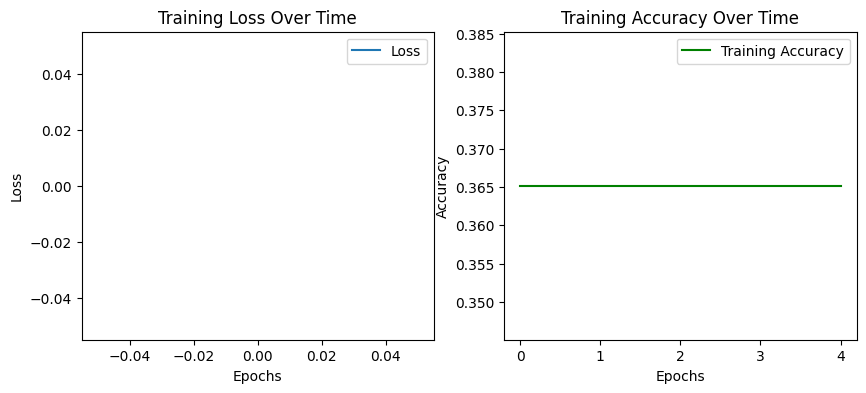

In [ ]:
plt.figure(figsize=(10,4))

# Loss Plot
plt.subplot(1,2,1)
plt.plot(train_losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()

# Accuracy Plot
plt.subplot(1,2,2)
plt.plot(train_accs, label="Training Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Time")
plt.legend()

plt.show()
